# ConvNet2 Convolutional Neural Network Classification Seed Value 7
Repository: https://github.com/ZainK-hub/satbinclass

This notebook uses the versions listed below of the following packages:
* Python: 3.7.4
* PANDAS: 0.25.1
* Numpy: 1.17.2
* Matplotlib: 3.1.1
* Scikit-learn: 0.21.3
* Scipy: 1.3.1
* Tensorflow-GPU 1.14.0
* Tensorflow 1.14.0
* CUDA toolkit: 10.1.168
* CUDNN: 7.6.0
* Keras-GPU: 2.2.4
* Keras-preprocessing: 1.1.0

In [1]:
#Seed random generators to ensure reproducible results
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed 
set_random_seed(7)
from math import ceil
import efficientnet.keras as efn
from efficientnet.keras import center_crop_and_resize #, preprocess_input

import time
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils, to_categorical, plot_model
from keras.applications import imagenet_utils, resnet50, resnet
from keras.applications import resnext
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
#from kerastuner.tuners import RandomSearch

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Nadam, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Add, Activation, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Average, Concatenate
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.backend import clear_session
#free GPU memory
clear_session()

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3

In [2]:
import tensorflow  as tf
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()


## Introduction

This notebook contains the code for image classification using a two-layered Convolutional Neural Network (ConvNet2). A new *random_state* or *seed* value of 7 is used in determining the data splits.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix, make_scorer
import pandas as pd

## Data preprocessing

The data is read in and preprocessed.

*StratifiedShuffleSplit* is used to ensure that the data is split and shuffled in such a way that the percentage of the categories of the data relative to the original dataset is maintained. A test dataset is made and separated from the dataset that will be used to train the model so as to not train on the data used to quantify the model performance since cross-validation is used.

In [4]:
X = np.load('X.npy')
y = np.load('y.npy')
#One hot encoding
one_hot_y = to_categorical(y)
#y = one_hot_y
print(X.shape)

(224, 224, 6, 1440)


In [5]:
print(y.shape)
y = np.ravel(y)
y.shape

(1440, 1)


(1440,)

In [6]:
img_res = X.shape[0]
blobs = X.shape[3]
X = X.T
print(X.shape)

(1440, 6, 224, 224)


In [7]:
#Scale the disp, ph and coh bands to 0 to 255
def scaleBandData(X):
    blobs = X.shape[0]
    bands = X.shape[1]
    print('band input shape', X.shape)
    X = X.T
    print('scale band data shape', X.shape)
    X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
    print('scale band data reshaped', X.shape)
    scaler = MinMaxScaler(feature_range=(0,255), copy=False)
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(blobs, bands, img_res, img_res)
    print('band output shape', X.shape)
    return X
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))
X[:,0:3,:,:] = scaleBandData(X[:,0:3,:,:])
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

max, min 3.1391279697418213 -3.1403708457946777
band input shape (1440, 3, 224, 224)
scale band data shape (224, 224, 3, 1440)
scale band data reshaped (1440, 150528)
band output shape (1440, 3, 224, 224)
max, min 255.00000000000006 0.0


In [8]:
print(X.shape)
print('max, min', np.max(X), np.min(X))

(1440, 6, 224, 224)
max, min 255.00000000000006 0.0


In [9]:
#Reshape to Keras desired shape
X = X.reshape(X.shape[0], X.shape[2], X.shape[3], X.shape[1])
print(X.shape)

(1440, 224, 224, 6)


## ConvNet2 Convolutional Neural Network (CNN) Classifier

A two-layered CNN classifier is implemented below. 

In [10]:
#Below code for multiple generator adapted from: https://github.com/keras-team/keras/issues/8130 
def multi_gen(generator, X, Y, batch_size, img_height,img_width):    
    gen_X0 = generator.flow(X[0], Y, batch_size = batch_size, shuffle=False, seed=7)    
    gen_X1 = generator.flow(X[1], batch_size = batch_size, shuffle=False, seed=7)
    
    while True:
            X0 = gen_X0.next()
            X1 = gen_X1.next()
            #Yield the 2 x 3 channel inputs and their mutual label
            #Had to rename input_2 to input_2_2 when renaming all layers in resnet_2
            yield ({'input_1': X0[0], 'input_2_2': X1[0]}, {'output': X0[1]})

#Below timing code adapted from: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
import time
class TimeHist(Callback):
    def at_train_start(self, logs={}):
        self.times = []

    def at_epoch_start(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def at_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
#Setup single models
def singleModel(folds, img_res, X_band_train, X_band_val, X_band_test, X_rgb_train, X_rgb_val, X_rgb_test, y_train, y_val, 
                y_test, train_index, val_index, single_model_name_str, results_arr, dropout, counter):
    
    weights_str = None
        
    img_h = img_res
    img_w = img_res
    batch_Size = 10 #8 #4 #16 #8 #10 #64
    
    print(single_model_name_str)
    
    training_size = X_band_train.shape[0]
    validating_size = X_band_val.shape[0]
    testing_size = X_band_test.shape[0]

    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

    input1 = Input(shape=(img_h, img_w, 3))
    net_1 = Conv2D(32, (3, 3,), activation='relu', padding='same')(input1)
    net_1 = BatchNormalization()(net_1)
    print(input1.shape)
    #print(net_1.shape)
    net_1 = MaxPool2D(pool_size=(2,2))(net_1)
    net_1 = Conv2D(64,  (3, 3,), activation='relu', padding='same')(net_1)
    net_1 = BatchNormalization()(net_1)
    net_1 = MaxPool2D(pool_size=(2,2))(net_1)
    net_1 = GlobalAveragePooling2D()(net_1)
    net_1 = Dropout(dropout)(net_1)
    preds1 = Dense(2, activation='softmax', name='Softmax_1')(net_1)
        
    input2 = Input(shape=(img_h, img_w, 3))
    net_2 = Conv2D(32,  (3, 3,), activation='relu', padding='same')(input2)    
    net_2 = BatchNormalization()(net_2)
    net_2 = MaxPool2D(pool_size=(2,2))(net_2)
    net_2 = Conv2D(64,  (3, 3,), activation='relu', padding='same')(net_2)
    net_2 = BatchNormalization()(net_2)
    net_2 = MaxPool2D(pool_size=(2,2))(net_2)
    net_2 = GlobalAveragePooling2D()(net_2)
    net_2 = Dropout(dropout)(net_2)
    preds2 = Dense(2, activation='softmax', name='Softmax_2')(net_2) 

    preds = Average()([preds1, preds2])

    #for layer in net_2.layers:
     #   layer.name = layer.name + str('_2')
    
    cnn_model = Model(inputs = [input1, input2], outputs = preds, name='ensemble')

    print(' 1 input shape:', input1.shape)
    print(' 1 output shape:', preds1.shape)
    
    optim = SGD(lr=1e-4, momentum=0.9)
    cnn_model.compile(loss='binary_crossentropy', optimizer = optim, metrics=['accuracy'])
    time_callback = TimeHist()
    chkpt_path = './model/' + single_model_name_str + '_Simple_Neural_Network_bestmodel.hdf5'
    checkpointer = ModelCheckpoint(filepath=chkpt_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)                

    input_imgen = ImageDataGenerator(shear_range = 0.30, zoom_range = 0.30, width_shift_range=0.3, 
                height_shift_range=0.3, rotation_range = 60, horizontal_flip = True, fill_mode='nearest')
    val_imgen = ImageDataGenerator()
    test_imgen = ImageDataGenerator()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=0, mode='auto', 
                                 min_lr=0.000001)
    callbacks_list = [checkpointer, time_callback, reduceLR, es,]
    
    train_generator = input_imgen.flow([X_band_train.copy(), X_rgb_train.copy()], y_train.copy(), 
                    batch_size=batch_Size, shuffle=False)
    val_generator = val_imgen.flow([X_band_val.copy(), X_rgb_val.copy()], y_val.copy(), batch_size=batch_Size, shuffle=False)
    test_generator = test_imgen.flow([X_band_test.copy(), X_rgb_test.copy()], batch_size=batch_Size, shuffle=False)
    
    history = cnn_model.fit_generator(train_generator, steps_per_epoch=round(training_size/batch_Size), epochs = 50, 
        callbacks=callbacks_list, validation_data = val_generator, validation_steps = ceil(validating_size/batch_Size), shuffle=False)

    test_preds = cnn_model.predict_generator(test_generator, steps=round(testing_size/batch_Size))
        
    #load the saved model
    saved_model = load_model(chkpt_path)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()
    
    train_preds = saved_model.predict_generator(train_generator, steps = round(training_size/batch_Size))
    val_preds = saved_model.predict_generator(val_generator, steps = ceil(validating_size/batch_Size))
    
    test_preds = saved_model.predict_generator(test_generator, steps = round(testing_size/batch_Size))
    print('validating_size', validating_size, 'val_preds', val_preds.shape, 'y_val: ', y_val.shape)
    
    val_acc = round(accuracy_score(np.argmax(y_val.copy(), axis=1), np.argmax(val_preds.copy(), axis=1))*100, 2)
    test_acc = round(accuracy_score(np.argmax(y_test.copy(), axis=1), np.argmax(test_preds.copy(), axis=1))*100, 2)
    print(single_model_name_str + ' : Counter: %i, Accuracies: Validation: %.2f %%, Test: %.2f %%' % (counter, 
            val_acc, test_acc))

    if counter == 0:
        plot_model(cnn_model, to_file= './model/' + single_model_name_str + '_' + str(folds) + '_folds_Simple_NN_Architecture.png')
    
    #Visualisation code adapted from Keras API dcumentation: https://keras.io/visualization/
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_' + str(folds) + '_folds_Simple_NN_Accuracy_' + str(counter) + '.png')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_' + str(folds) + '_folds_Simple_NN_Loss_' + str(counter) + '.png')
    plt.show()

    del history, saved_model, cnn_model
    
    results_arr.append(val_acc)
    results_arr.append(test_acc)     
    results_arr = evaluator(np.round(np.argmax(test_preds.copy(),axis=1)), np.argmax(y_test.copy(), axis=1), results_arr)
    
    del X_band_train, X_rgb_train, X_band_val, X_rgb_val, y_train, y_val, y_test, X_band_test, X_rgb_test
    clear_session()
    del net_1, net_2, train_preds 
    return val_preds, test_preds, results_arr


#Evaluate performance
def evaluator(test_preds, y_test, results_arr):
    f1_sco = round(f1_score(y_test, np.round(test_preds), average='macro'), 2)
    precision = round(precision_score(y_test, np.round(test_preds), average='macro'), 2)
    recall = round(recall_score(y_test, np.round(test_preds), average='macro'), 2)
    print('F1 score is: ', f1_sco)
    print('Recall score is: ', precision)
    print('Precision score is: ', recall)

    confu = confusion_matrix(y_test, test_preds)
    print('Confusion matrix: \n', confu)
    print('From the confusion matrix above there are ' + str(confu[0, 0]) + ' true negatives and ' + str(confu[0, 1]) 
          + ' false positives.') 
    print('There are ' + str(confu[1, 0]) + ' false negatives and ' + str(confu[1, 1]) + ' true positives. \n')
    performance = np.array((f1_sco, precision, recall, confu[0, 0], confu[0, 1], confu[1, 0], confu[1, 1]))
    for i in range(len(performance)):
        results_arr.append(performance[i])
    return results_arr
    
#Ensemble models
def ensembler(val_preds, test_preds, y_val, y_test, ensemble_str, results_arr):
    val_preds = np.mean(val_preds, axis=0)
    test_preds = np.mean(test_preds, axis=0)
    ensemble_preds_val = np.argmax(val_preds, axis=1)
    ensemble_preds_test = np.argmax(test_preds, axis=1)
    ensemble_val_acc = np.round(accuracy_score(y_val, np.round(ensemble_preds_val))*100, 2)
    print('Validation score of ' + ensemble_str + ': ', ensemble_val_acc, '%')
    ensemble_test_acc = np.round(accuracy_score(y_test.copy(), np.round(ensemble_preds_test))*100, 2)
    print('Test score of ' + ensemble_str + ': ', ensemble_test_acc, '%')
     
    results_arr.append(ensemble_val_acc)
    results_arr.append(ensemble_test_acc)
    results_arr = evaluator(np.round(ensemble_preds_test.copy()), y_test.copy(), results_arr)
    return results_arr

In [12]:
def reshaper(X):
    X_reshaped = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
    return X_reshaped, X.shape[0]

def shapeExpander(X, num_blobs, num_bands):
    X_reshaped = X.reshape(num_blobs, img_res, img_res, num_bands)
    return X_reshaped

def scaleData(X_train, X_val, X_test):
    print('Train, Val and Test Data shapes: ', X_train.shape, X_val.shape, X_test.shape)
    X_train, train_no = reshaper(X_train)
    X_val, val_no = reshaper(X_val)
    X_test, test_no = reshaper(X_test)
    print('Reshaped Train, Val and Test Data shapes: ', X_train.shape, X_val.shape, X_test.shape)

    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = shapeExpander(X_train_scaled, train_no, 3)
    X_val_scaled = shapeExpander(X_val_scaled, val_no, 3)
    X_test_scaled = shapeExpander(X_test_scaled, test_no, 3)
    print('Train, Scaled Val and Scaled Test Data shapes: ', X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
    del scaler, X_train, X_val, X_test
    return X_train_scaled, X_val_scaled, X_test_scaled


#Function to train model 
def trainModel(folds, img_res, X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test, 
               y_train_val, y_test):
        
    sss = StratifiedShuffleSplit(n_splits=folds, test_size=0.2, random_state=7)
    sss.get_n_splits(X_band_train_val, y_train_val)

    dropout=[0.2, 0.3, 0.4]
    single_model_name = ['Simple NN Seed 7 Dropout: ' + str(dropout[0]), 'Simple NN Seed 7 Dropout: ' + str(dropout[1]), 
                         'Simple NN Seed 7 Dropout: ' + str(dropout[2]),]
    for i in range(len(single_model_name)):
        print('Model ' + str(i + 1) + ': ' + single_model_name[i])
    
    #Results column names
    col_names = ['Counter',]
    subnames = ['Val Acc', 'Test Acc', 'F1 score', 'Precision', 'Recall', 'True Neg.', 'False Pos.', 'False Neg.', 'True Pos.',]
    for i in range(len(single_model_name)):
        for j in range(len(subnames)):
            col_names.append(single_model_name[i] + ' ' + subnames[j])
    """
    ensemble_names = ['Ensemble of 1 & 2',]
    for i in range(len(ensemble_names)):
        for j in range(len(subnames)):
            col_names.append(ensemble_names[i] + ' ' + subnames[j])
    """
    results_data = pd.DataFrame(columns=col_names)
    results_arr = []
    
    counter = 0
    for train_index, val_index in sss.split(X_band_train_val, y_train_val):
        #Test to see if there any overlapped indices
        print('Overlap',set(train_index) & set (val_index))
        print('Counter: ',counter)
        print(datetime.now())
        results_arr.append(counter)
        
        y_train = y_train_val[train_index].copy()
        y_val = y_train_val[val_index].copy()
        y_test = y_test.copy()
        
        X_band_train = X_band_train_val[train_index].copy()
        X_band_val = X_band_train_val[val_index].copy()
        X_band_test_copy = X_band_test.copy()
        X_rgb_train = X_rgb_train_val[train_index].copy()
        X_rgb_val = X_rgb_train_val[val_index].copy()
        X_rgb_test_copy = X_rgb_test.copy()
        print('Band: Train: ', X_band_train.shape, 'Validation:', X_band_val.shape, 'Test:', X_band_test.shape)         
        print('RGB: Train: ', X_rgb_train.shape, 'Validation:', X_rgb_val.shape, 'Test:', X_rgb_test.shape)         
                
        X_band_train, X_band_val, X_band_test_copy = scaleData(X_band_train, X_band_val, X_band_test_copy)
        X_rgb_train, X_rgb_val, X_rgb_test_copy = scaleData(X_rgb_train, X_rgb_val, X_rgb_test_copy)
        
        # Model 1
        preds_1, test_preds_1, results_arr = singleModel(folds, img_res, X_band_train.copy(), X_band_val.copy(), 
            X_band_test_copy.copy(), X_rgb_train.copy(), X_rgb_val.copy(), X_rgb_test_copy.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[0], results_arr, dropout[0], counter)
           
        preds_2, test_preds_2, results_arr = singleModel(folds, img_res, X_band_train.copy(), X_band_val.copy(), 
            X_band_test_copy.copy(), X_rgb_train.copy(), X_rgb_val.copy(), X_rgb_test_copy.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[1], results_arr, dropout[1], counter)

        preds_3, test_preds_3, results_arr = singleModel(folds, img_res, X_band_train.copy(), X_band_val.copy(), 
            X_band_test_copy.copy(), X_rgb_train.copy(), X_rgb_val.copy(), X_rgb_test_copy.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[2], results_arr, dropout[2], counter)
              
        #Append to data frame    
        temp_df2 = pd.DataFrame([results_arr], columns=col_names) 
        results_data = results_data.append(temp_df2, ignore_index=True, sort=False)
        print('results_data \n\n', results_data)
        results_arr.clear()
            
        counter = counter + 1
        del y_train, y_val, 
        #New del
        del X_band_train, X_band_val, X_band_test_copy, X_rgb_train, X_rgb_val, X_rgb_test_copy
        
    print('10-fold cross validation has completed. \n Mean scores are :')
    print(results_data.mean(axis=0))
    results_copy  = results_data.copy()
    temp_df2 = pd.DataFrame(results_data.mean(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.var(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.std(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)

    del X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test
    return results_data

2021-08-16 02:33:00.337172
X, y shapes:  (1440, 224, 224, 6) (1440,)
X_band_train_val processed: max, min 255.0 0.0
X_rgb_train_val processed: max, min 255.0 0.0
X_band_test processed: max, min 255.0 0.0
X_rgb_test processed: max, min 255.0 0.0
Model 1: Simple NN Seed 7 Dropout: 0.2
Model 2: Simple NN Seed 7 Dropout: 0.3
Model 3: Simple NN Seed 7 Dropout: 0.4
Overlap set()
Counter:  0
2021-08-16 02:33:02.269797
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
Train, Val and Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Reshaped Train, Val and Test Data shapes:  (921, 150528) (231, 150528) (288, 150528)
Train, Scaled Val and Scaled Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Train, Val and Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Reshaped Train, Val and Test Data sh

92/92 [==============================] - 7s 74ms/step - loss: 0.3866 - acc: 0.8163 - val_loss: 0.3996 - val_acc: 0.8182

Epoch 00021: val_loss improved from 0.40081 to 0.39965, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 22/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3804 - acc: 0.8206 - val_loss: 0.4012 - val_acc: 0.8182

Epoch 00022: val_loss did not improve from 0.39965
Epoch 23/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3986 - acc: 0.8337 - val_loss: 0.3971 - val_acc: 0.8182

Epoch 00023: val_loss improved from 0.39965 to 0.39708, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 24/50
92/92 [==============================] - 7s 74ms/step - loss: 0.3920 - acc: 0.8195 - val_loss: 0.3968 - val_acc: 0.8182

Epoch 00024: val_loss improved from 0.39708 to 0.39680, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bes

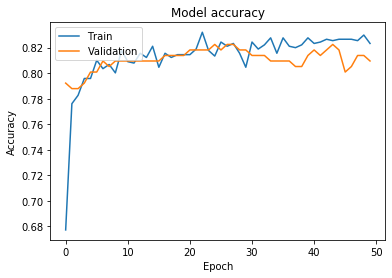

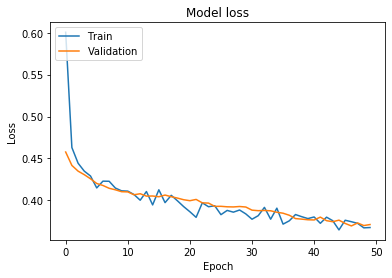

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[114  30]
 [ 20 124]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 20 false negatives and 124 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.5836 - acc: 0.6946 - val_loss: 0.5509 - val_acc: 0.6926

Epoch 00001: val_loss improved from inf to 0.55089, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4695 - acc: 0.7642 - val_loss: 0.4730 - val_acc: 0.7922

Epoch 00002: val_loss improved from 0.55089 to 0.47299, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4578 - acc: 0.78

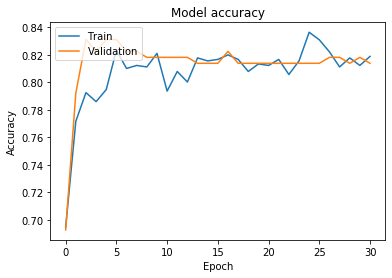

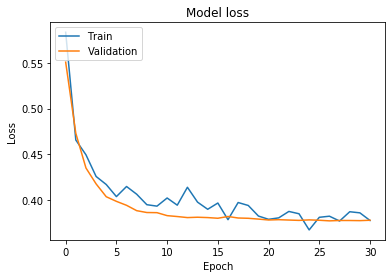

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[117  27]
 [ 26 118]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 26 false negatives and 118 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5645 - acc: 0.7120 - val_loss: 0.4903 - val_acc: 0.7706

Epoch 00001: val_loss improved from inf to 0.49030, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4724 - acc: 0.7740 - val_loss: 0.4535 - val_acc: 0.7879

Epoch 00002: val_loss improved from 0.49030 to 0.45349, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4592 - acc: 0.79

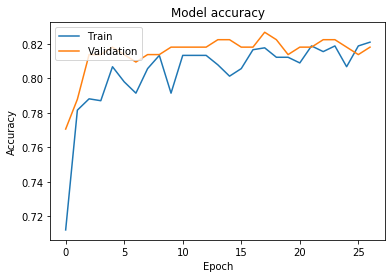

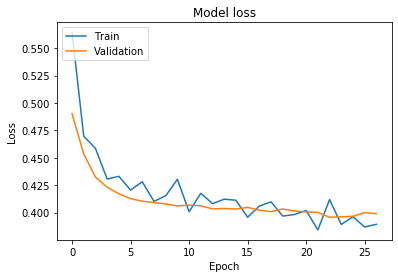

F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[113  31]
 [ 25 119]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 25 false negatives and 119 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   

   Simple NN Seed 7 Dropout: 0.2 F1 score  \
0                                    0.83   

   Simple NN Seed 7 Dropout: 0.2 Precision  \
0                                     0.83   

   Simple NN Seed 7 Dropout: 0.2 Recall  \
0                                  0.83   

   Simple NN Seed 7 Dropout: 0.2 True Neg.  \
0                                    114.0   

   Simple NN Seed 7 Dropout: 0.2 False Pos.  \
0                                      30.0   

   Simple NN Seed 7 Dropout: 0.2 False Neg.  \
0                              


Epoch 00021: val_loss did not improve from 0.35444
Epoch 22/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4130 - acc: 0.7881 - val_loss: 0.3547 - val_acc: 0.8182

Epoch 00022: val_loss did not improve from 0.35444
Epoch 00022: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
Simple NN Seed 7 Dropout: 0.2 : Counter: 1, Accuracies: Validation: 82.25 %, Test: 81.94 %


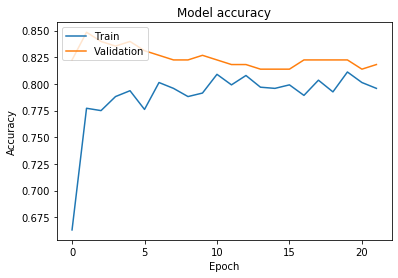

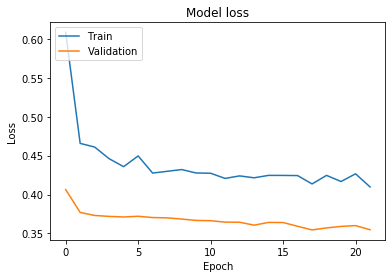

F1 score is:  0.82
Recall score is:  0.83
Precision score is:  0.82
Confusion matrix: 
 [[108  36]
 [ 16 128]]
From the confusion matrix above there are 108 true negatives and 36 false positives.
There are 16 false negatives and 128 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 84ms/step - loss: 0.5614 - acc: 0.7087 - val_loss: 0.4247 - val_acc: 0.8095

Epoch 00001: val_loss improved from inf to 0.42471, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4817 - acc: 0.7544 - val_loss: 0.3824 - val_acc: 0.8268

Epoch 00002: val_loss improved from 0.42471 to 0.38235, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4696 - acc: 0.77

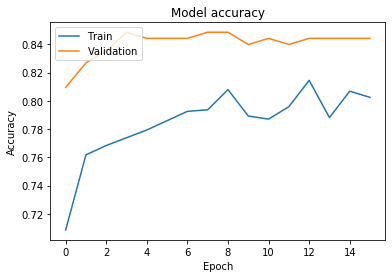

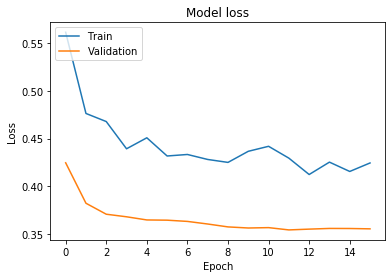

F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[110  34]
 [ 21 123]]
From the confusion matrix above there are 110 true negatives and 34 false positives.
There are 21 false negatives and 123 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.5535 - acc: 0.7359 - val_loss: 0.3897 - val_acc: 0.8268

Epoch 00001: val_loss improved from inf to 0.38968, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.5007 - acc: 0.7599 - val_loss: 0.3758 - val_acc: 0.8528

Epoch 00002: val_loss improved from 0.38968 to 0.37583, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4746 - acc: 0.77

92/92 [==============================] - 7s 74ms/step - loss: 0.4129 - acc: 0.8033 - val_loss: 0.3518 - val_acc: 0.8442

Epoch 00034: val_loss did not improve from 0.35121
Epoch 35/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4370 - acc: 0.7903 - val_loss: 0.3512 - val_acc: 0.8398

Epoch 00035: val_loss did not improve from 0.35121
Epoch 36/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4218 - acc: 0.7957 - val_loss: 0.3502 - val_acc: 0.8442

Epoch 00036: val_loss improved from 0.35121 to 0.35025, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 37/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4466 - acc: 0.7902 - val_loss: 0.3508 - val_acc: 0.8398

Epoch 00037: val_loss did not improve from 0.35025
Epoch 38/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4275 - acc: 0.7860 - val_loss: 0.3508 - val_acc: 0.8398

Epoch 00038: val_loss did not improve from 0.35

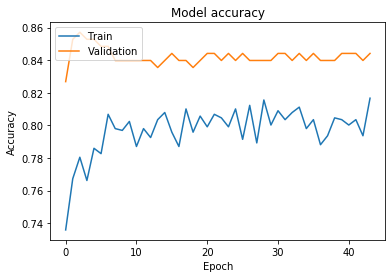

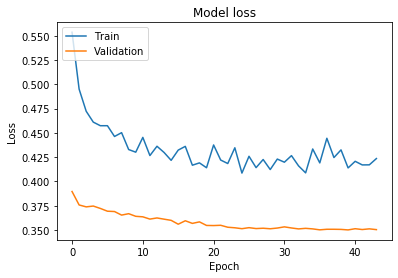

F1 score is:  0.82
Recall score is:  0.83
Precision score is:  0.82
Confusion matrix: 
 [[111  33]
 [ 18 126]]
From the confusion matrix above there are 111 true negatives and 33 false positives.
There are 18 false negatives and 126 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   

   Simple NN Seed 7 Dropout: 0.2 F1 score  \
0                                    0.83   
1                                    0.82   

   Simple NN Seed 7 Dropout: 0.2 Precision  \
0                                     0.83   
1                                     0.83   

   Simple NN Seed 7 Dropout: 0.2 Recall  \
0                                  0.83   
1                                  0.82   

   Simple NN Seed 7 Dropout: 0.2 Tr

92/92 [==============================] - 7s 76ms/step - loss: 0.4046 - acc: 0.8239 - val_loss: 0.4075 - val_acc: 0.8052

Epoch 00018: val_loss did not improve from 0.40369
Epoch 00018: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
Simple NN Seed 7 Dropout: 0.2 : Counter: 2, Accuracies: Validation: 80.52 %, Test: 81.60 %


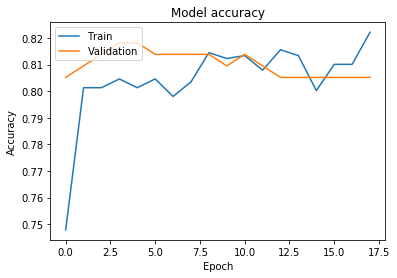

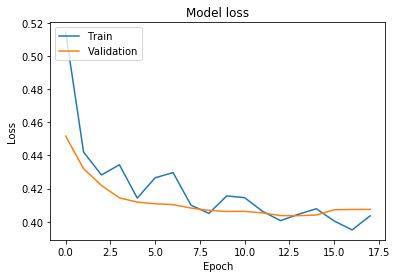

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[109  35]
 [ 18 126]]
From the confusion matrix above there are 109 true negatives and 35 false positives.
There are 18 false negatives and 126 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.5921 - acc: 0.6793 - val_loss: 0.4408 - val_acc: 0.7922

Epoch 00001: val_loss improved from inf to 0.44083, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 71ms/step - loss: 0.4621 - acc: 0.7837 - val_loss: 0.4079 - val_acc: 0.8095

Epoch 00002: val_loss improved from 0.44083 to 0.40795, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4446 - acc: 0.79

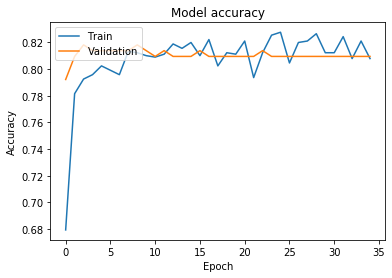

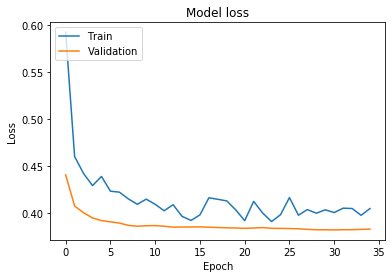

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[112  32]
 [ 21 123]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 21 false negatives and 123 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.6397 - acc: 0.6098 - val_loss: 0.4663 - val_acc: 0.7879

Epoch 00001: val_loss improved from inf to 0.46631, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.5107 - acc: 0.7619 - val_loss: 0.4256 - val_acc: 0.8225

Epoch 00002: val_loss improved from 0.46631 to 0.42556, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4761 - acc: 0.79

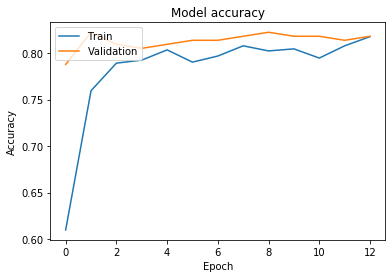

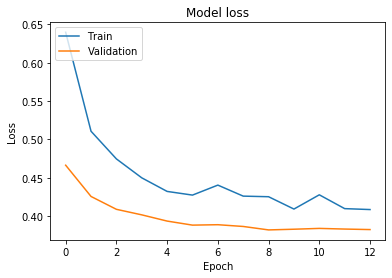

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[116  28]
 [ 24 120]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 24 false negatives and 120 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   
2       2                                  80.52   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   
2                                   81.60   

   Simple NN Seed 7 Dropout: 0.2 F1 score  \
0                                    0.83   
1                                    0.82   
2                                    0.82   

   Simple NN Seed 7 Dropout: 0.2 Precision  \
0                                     0.83   
1                                     0.83   
2                       

92/92 [==============================] - 7s 74ms/step - loss: 0.3915 - acc: 0.8293 - val_loss: 0.3926 - val_acc: 0.7879

Epoch 00014: val_loss improved from 0.39290 to 0.39264, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 15/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3898 - acc: 0.8195 - val_loss: 0.3912 - val_acc: 0.7965

Epoch 00015: val_loss improved from 0.39264 to 0.39118, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 16/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3921 - acc: 0.8228 - val_loss: 0.3923 - val_acc: 0.7792

Epoch 00016: val_loss did not improve from 0.39118
Epoch 17/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3835 - acc: 0.8217 - val_loss: 0.3907 - val_acc: 0.7835

Epoch 00017: val_loss improved from 0.39118 to 0.39074, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bes

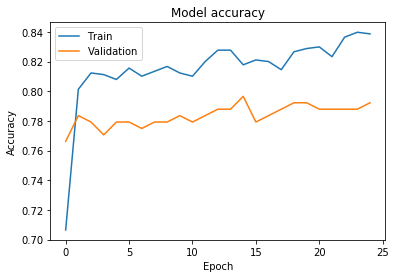

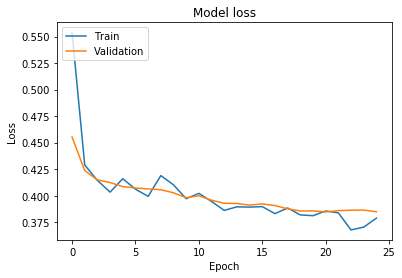

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[117  27]
 [ 23 121]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 23 false negatives and 121 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.7061 - acc: 0.5685 - val_loss: 0.4978 - val_acc: 0.7100

Epoch 00001: val_loss improved from inf to 0.49778, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4689 - acc: 0.7740 - val_loss: 0.4484 - val_acc: 0.7489

Epoch 00002: val_loss improved from 0.49778 to 0.44842, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4385 - acc: 0.80

92/92 [==============================] - 7s 74ms/step - loss: 0.3793 - acc: 0.8293 - val_loss: 0.3880 - val_acc: 0.7922

Epoch 00032: val_loss did not improve from 0.38561
Epoch 33/50
92/92 [==============================] - 7s 76ms/step - loss: 0.3953 - acc: 0.8337 - val_loss: 0.3827 - val_acc: 0.7965

Epoch 00033: val_loss improved from 0.38561 to 0.38272, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 34/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3760 - acc: 0.8326 - val_loss: 0.3827 - val_acc: 0.8009

Epoch 00034: val_loss improved from 0.38272 to 0.38266, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 35/50
92/92 [==============================] - 7s 74ms/step - loss: 0.3806 - acc: 0.8467 - val_loss: 0.3801 - val_acc: 0.8052

Epoch 00035: val_loss improved from 0.38266 to 0.38011, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bes

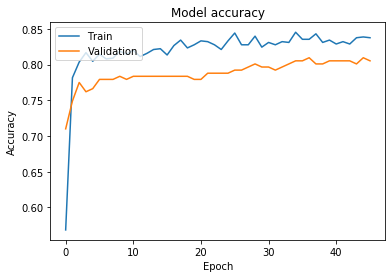

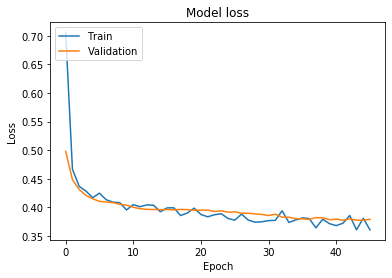

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[117  27]
 [ 25 119]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 25 false negatives and 119 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.6340 - acc: 0.6717 - val_loss: 0.5063 - val_acc: 0.7316

Epoch 00001: val_loss improved from inf to 0.50630, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4644 - acc: 0.7956 - val_loss: 0.4470 - val_acc: 0.7792

Epoch 00002: val_loss improved from 0.50630 to 0.44698, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4543 - acc: 0.79

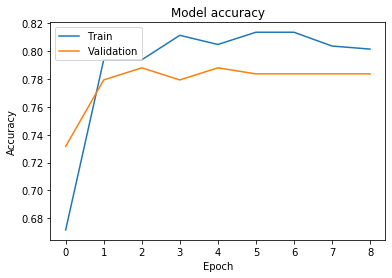

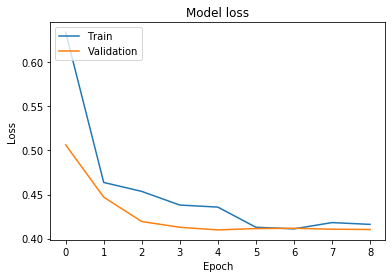

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[118  26]
 [ 22 122]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 22 false negatives and 122 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   
2       2                                  80.52   
3       3                                  78.79   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   
2                                   81.60   
3                                   82.64   

   Simple NN Seed 7 Dropout: 0.2 F1 score  \
0                                    0.83   
1                                    0.82   
2                                    0.82   
3                                    0.83   

   Simple NN Seed 7 


Epoch 00010: val_loss improved from 0.39690 to 0.39559, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 11/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4036 - acc: 0.8163 - val_loss: 0.3937 - val_acc: 0.7922

Epoch 00011: val_loss improved from 0.39559 to 0.39373, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 12/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4036 - acc: 0.8185 - val_loss: 0.3935 - val_acc: 0.7965

Epoch 00012: val_loss improved from 0.39373 to 0.39352, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 13/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4026 - acc: 0.8098 - val_loss: 0.3922 - val_acc: 0.7965

Epoch 00013: val_loss improved from 0.39352 to 0.39225, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 14/50


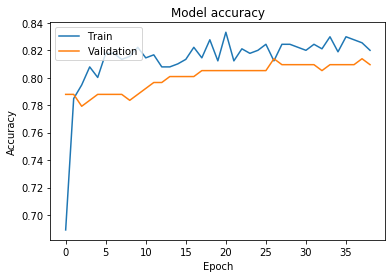

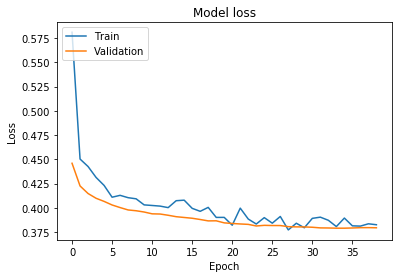

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[118  26]
 [ 21 123]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 21 false negatives and 123 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5272 - acc: 0.7348 - val_loss: 0.4133 - val_acc: 0.7922

Epoch 00001: val_loss improved from inf to 0.41326, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 71ms/step - loss: 0.4579 - acc: 0.7945 - val_loss: 0.4067 - val_acc: 0.7922

Epoch 00002: val_loss improved from 0.41326 to 0.40672, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4351 - acc: 0.80

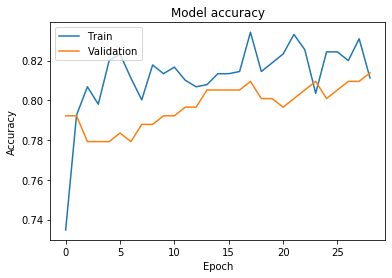

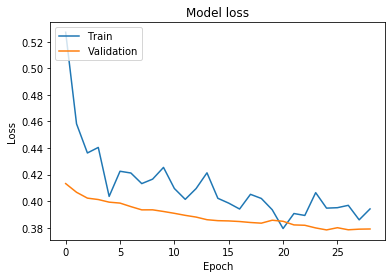

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[117  27]
 [ 21 123]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 21 false negatives and 123 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.5876 - acc: 0.6826 - val_loss: 0.4611 - val_acc: 0.7835

Epoch 00001: val_loss improved from inf to 0.46111, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4908 - acc: 0.7599 - val_loss: 0.4436 - val_acc: 0.7835

Epoch 00002: val_loss improved from 0.46111 to 0.44358, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4682 - acc: 0.78


Epoch 00032: val_loss did not improve from 0.38621
Epoch 33/50
92/92 [==============================] - 7s 76ms/step - loss: 0.3957 - acc: 0.8152 - val_loss: 0.3882 - val_acc: 0.8095

Epoch 00033: val_loss did not improve from 0.38621
Epoch 34/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3887 - acc: 0.8163 - val_loss: 0.3873 - val_acc: 0.8139

Epoch 00034: val_loss did not improve from 0.38621
Epoch 00034: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
Simple NN Seed 7 Dropout: 0.4 : Counter: 4, Accuracies: Validation: 80.95 %, Test: 82.29 %


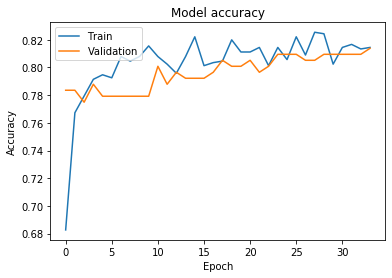

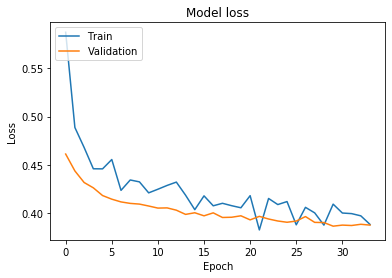

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[115  29]
 [ 22 122]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 22 false negatives and 122 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   
2       2                                  80.52   
3       3                                  78.79   
4       4                                  80.95   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   
2                                   81.60   
3                                   82.64   
4                                   83.68   

   Simple NN Seed 7 Dropout: 0.2 F1 score  \
0                                    0.83   
1                                    0.82   
2             

92/92 [==============================] - 7s 75ms/step - loss: 0.3856 - acc: 0.8348 - val_loss: 0.3138 - val_acc: 0.8442

Epoch 00038: val_loss improved from 0.31396 to 0.31382, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 39/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3831 - acc: 0.8337 - val_loss: 0.3136 - val_acc: 0.8442

Epoch 00039: val_loss improved from 0.31382 to 0.31364, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 40/50
92/92 [==============================] - 7s 74ms/step - loss: 0.3761 - acc: 0.8435 - val_loss: 0.3128 - val_acc: 0.8485

Epoch 00040: val_loss improved from 0.31364 to 0.31276, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 41/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3684 - acc: 0.8282 - val_loss: 0.3122 - val_acc: 0.8442

Epoch 00041: val_loss improved from 0.3

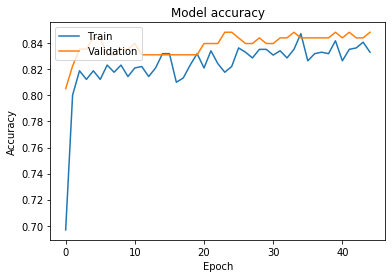

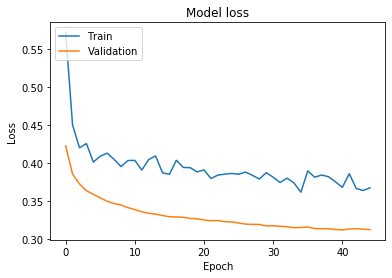

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[114  30]
 [ 20 124]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 20 false negatives and 124 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5565 - acc: 0.7315 - val_loss: 0.4051 - val_acc: 0.8398

Epoch 00001: val_loss improved from inf to 0.40512, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4768 - acc: 0.7653 - val_loss: 0.3795 - val_acc: 0.8485

Epoch 00002: val_loss improved from 0.40512 to 0.37946, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4612 - acc: 0.78

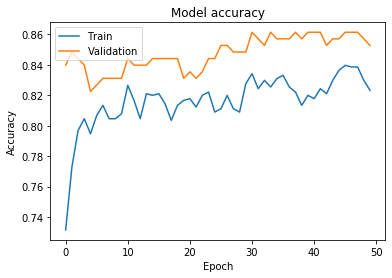

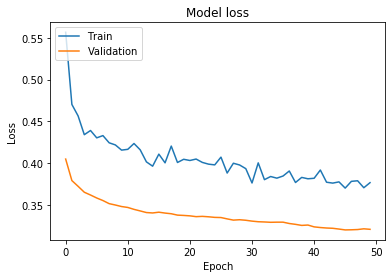

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[119  25]
 [ 22 122]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 22 false negatives and 122 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5973 - acc: 0.6750 - val_loss: 0.4070 - val_acc: 0.8182

Epoch 00001: val_loss improved from inf to 0.40702, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4692 - acc: 0.7652 - val_loss: 0.3806 - val_acc: 0.8182

Epoch 00002: val_loss improved from 0.40702 to 0.38064, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4580 - acc: 0.79

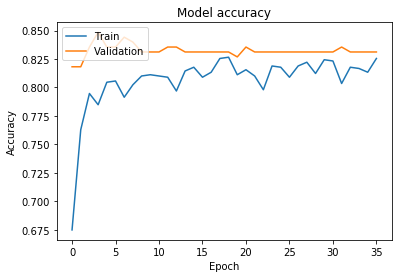

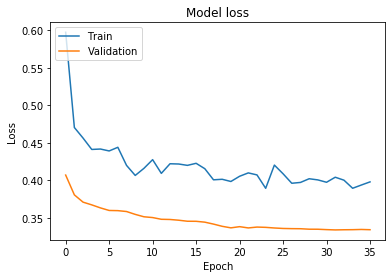

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[113  31]
 [ 22 122]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 22 false negatives and 122 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   
2       2                                  80.52   
3       3                                  78.79   
4       4                                  80.95   
5       5                                  84.42   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   
2                                   81.60   
3                                   82.64   
4                                   83.68   
5                                   82.64   

   Simple NN Seed 7 Dropout: 0.2 F1 score  \
0      

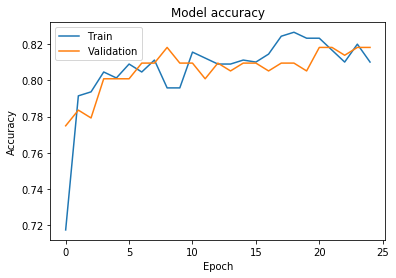

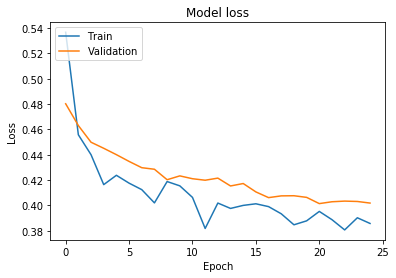

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[112  32]
 [ 21 123]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 21 false negatives and 123 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5798 - acc: 0.6576 - val_loss: 0.4863 - val_acc: 0.7792

Epoch 00001: val_loss improved from inf to 0.48634, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4760 - acc: 0.7599 - val_loss: 0.4715 - val_acc: 0.7922

Epoch 00002: val_loss improved from 0.48634 to 0.47145, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4587 - acc: 0.76

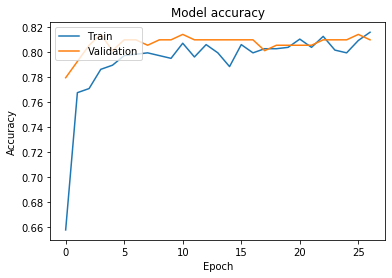

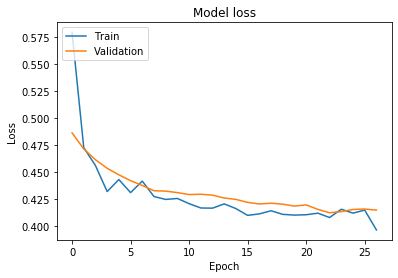

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[113  31]
 [ 21 123]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 21 false negatives and 123 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.6109 - acc: 0.6587 - val_loss: 0.5053 - val_acc: 0.7489

Epoch 00001: val_loss improved from inf to 0.50527, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 71ms/step - loss: 0.4974 - acc: 0.7631 - val_loss: 0.4614 - val_acc: 0.7835

Epoch 00002: val_loss improved from 0.50527 to 0.46143, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4710 - acc: 0.76


Epoch 00030: val_loss did not improve from 0.38329
Epoch 31/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4191 - acc: 0.8001 - val_loss: 0.3821 - val_acc: 0.8268

Epoch 00031: val_loss improved from 0.38329 to 0.38205, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 32/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4064 - acc: 0.7968 - val_loss: 0.3840 - val_acc: 0.8268

Epoch 00032: val_loss did not improve from 0.38205
Epoch 33/50
92/92 [==============================] - 7s 74ms/step - loss: 0.3942 - acc: 0.8186 - val_loss: 0.3812 - val_acc: 0.8268

Epoch 00033: val_loss improved from 0.38205 to 0.38116, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 34/50
92/92 [==============================] - 7s 76ms/step - loss: 0.3913 - acc: 0.8141 - val_loss: 0.3793 - val_acc: 0.8355

Epoch 00034: val_loss improved from 0.38116 to 0.37929, saving model to

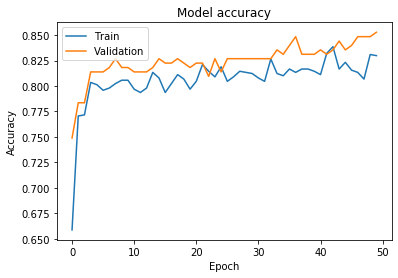

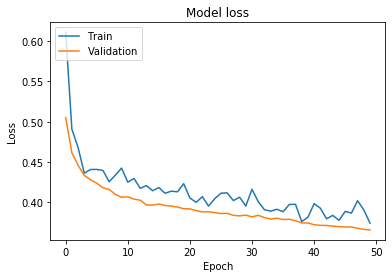

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[116  28]
 [ 24 120]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 24 false negatives and 120 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   
2       2                                  80.52   
3       3                                  78.79   
4       4                                  80.95   
5       5                                  84.42   
6       6                                  81.82   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   
2                                   81.60   
3                                   82.64   
4                                   83.68   
5                                   82.64   
6

Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.5603 - acc: 0.7098 - val_loss: 0.4337 - val_acc: 0.7619

Epoch 00001: val_loss improved from inf to 0.43371, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4826 - acc: 0.7750 - val_loss: 0.4004 - val_acc: 0.8009

Epoch 00002: val_loss improved from 0.43371 to 0.40035, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4469 - acc: 0.7827 - val_loss: 0.3839 - val_acc: 0.8139

Epoch 00003: val_loss improved from 0.40035 to 0.38392, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 4/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4370 - acc: 0.7967 - val_loss: 0.3747 - val_acc: 0.8225

Epoch 00004: val_loss improved from


Epoch 00033: val_loss did not improve from 0.33587
Epoch 34/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4131 - acc: 0.8206 - val_loss: 0.3362 - val_acc: 0.8312

Epoch 00034: val_loss did not improve from 0.33587
Epoch 35/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3933 - acc: 0.8087 - val_loss: 0.3366 - val_acc: 0.8268

Epoch 00035: val_loss did not improve from 0.33587
Epoch 36/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4096 - acc: 0.8011 - val_loss: 0.3368 - val_acc: 0.8268

Epoch 00036: val_loss did not improve from 0.33587
Epoch 00036: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
Simple NN Seed 7 Dropout: 0.2 : Counter: 7, Accuracies: Validation: 83.12 %, Test: 82.64 %


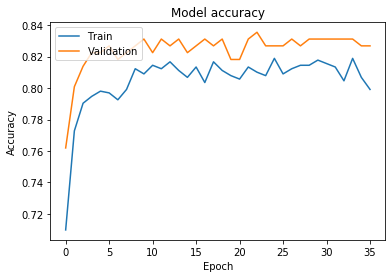

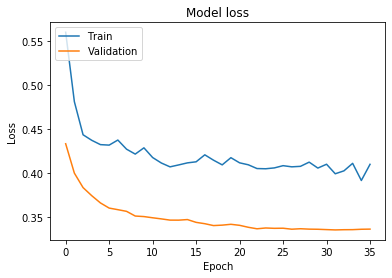

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[117  27]
 [ 23 121]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 23 false negatives and 121 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 84ms/step - loss: 0.5246 - acc: 0.7435 - val_loss: 0.4105 - val_acc: 0.8009

Epoch 00001: val_loss improved from inf to 0.41046, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4632 - acc: 0.7924 - val_loss: 0.3903 - val_acc: 0.8052

Epoch 00002: val_loss improved from 0.41046 to 0.39031, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4522 - acc: 0.79

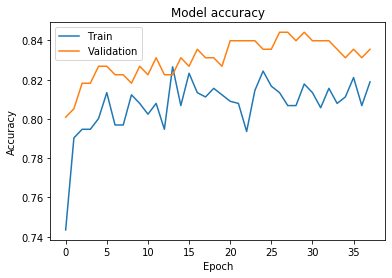

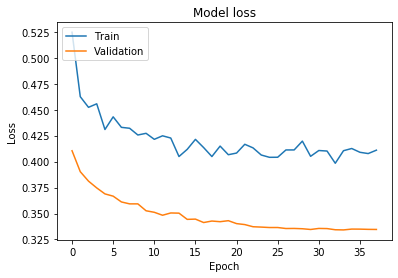

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[117  27]
 [ 22 122]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 22 false negatives and 122 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.5797 - acc: 0.6837 - val_loss: 0.4336 - val_acc: 0.7662

Epoch 00001: val_loss improved from inf to 0.43360, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4987 - acc: 0.7695 - val_loss: 0.4129 - val_acc: 0.7662

Epoch 00002: val_loss improved from 0.43360 to 0.41294, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4791 - acc: 0.78

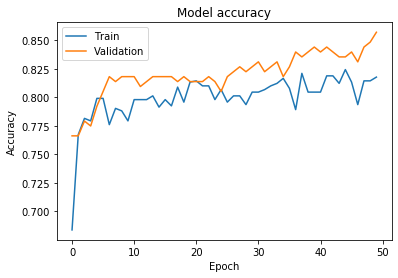

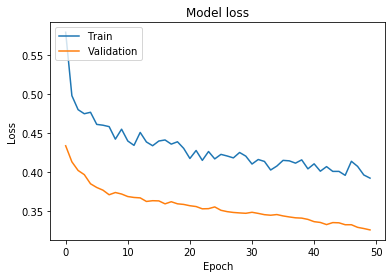

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[117  27]
 [ 22 122]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 22 false negatives and 122 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   
2       2                                  80.52   
3       3                                  78.79   
4       4                                  80.95   
5       5                                  84.42   
6       6                                  81.82   
7       7                                  83.12   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   
2                                   81.60   
3                                   82.64   
4                                   83.

Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
Train, Val and Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Reshaped Train, Val and Test Data shapes:  (921, 150528) (231, 150528) (288, 150528)
Train, Scaled Val and Scaled Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Train, Val and Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Reshaped Train, Val and Test Data shapes:  (921, 150528) (231, 150528) (288, 150528)
Train, Scaled Val and Scaled Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Simple NN Seed 7 Dropout: 0.2
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 84ms/step - loss: 0.5050 - acc: 0.7793 - val_loss: 0.4656 - val_acc: 0.7576

Epoch 00001: val_loss imp

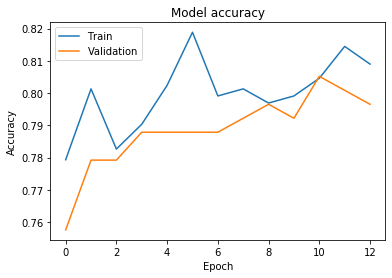

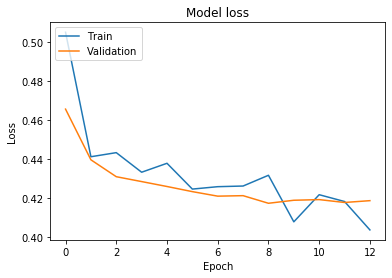

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[109  35]
 [ 22 122]]
From the confusion matrix above there are 109 true negatives and 35 false positives.
There are 22 false negatives and 122 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.6144 - acc: 0.6565 - val_loss: 0.4343 - val_acc: 0.7749

Epoch 00001: val_loss improved from inf to 0.43427, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4667 - acc: 0.7880 - val_loss: 0.4201 - val_acc: 0.7835

Epoch 00002: val_loss improved from 0.43427 to 0.42014, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4598 - acc: 0.7967 

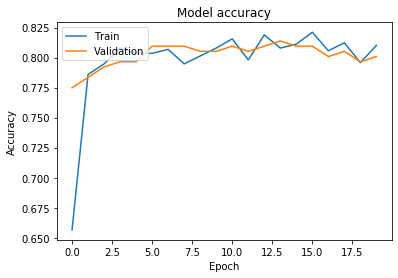

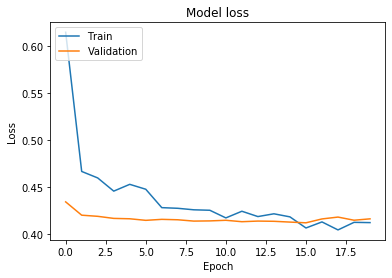

F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[113  31]
 [ 23 121]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 23 false negatives and 121 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 83ms/step - loss: 0.6185 - acc: 0.6489 - val_loss: 0.4811 - val_acc: 0.7835

Epoch 00001: val_loss improved from inf to 0.48106, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.5143 - acc: 0.7685 - val_loss: 0.4537 - val_acc: 0.7792

Epoch 00002: val_loss improved from 0.48106 to 0.45369, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 74ms/step - loss: 0.4792 - acc: 0.78

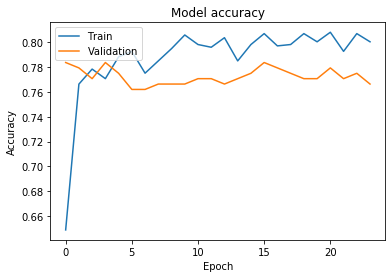

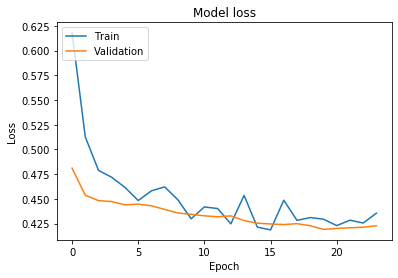

F1 score is:  0.8
Recall score is:  0.81
Precision score is:  0.8
Confusion matrix: 
 [[102  42]
 [ 16 128]]
From the confusion matrix above there are 102 true negatives and 42 false positives.
There are 16 false negatives and 128 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   
2       2                                  80.52   
3       3                                  78.79   
4       4                                  80.95   
5       5                                  84.42   
6       6                                  81.82   
7       7                                  83.12   
8       8                                  79.65   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   
2                                   81.60   
3                                 

Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
Train, Val and Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Reshaped Train, Val and Test Data shapes:  (921, 150528) (231, 150528) (288, 150528)
Train, Scaled Val and Scaled Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Train, Val and Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Reshaped Train, Val and Test Data shapes:  (921, 150528) (231, 150528) (288, 150528)
Train, Scaled Val and Scaled Test Data shapes:  (921, 224, 224, 3) (231, 224, 224, 3) (288, 224, 224, 3)
Simple NN Seed 7 Dropout: 0.2
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.5254 - acc: 0.7489 - val_loss: 0.4331 - val_acc: 0.7965

Epoch 00001: val_loss imp

92/92 [==============================] - 7s 75ms/step - loss: 0.3796 - acc: 0.8272 - val_loss: 0.3677 - val_acc: 0.7879

Epoch 00029: val_loss improved from 0.36848 to 0.36766, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 30/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3977 - acc: 0.8174 - val_loss: 0.3669 - val_acc: 0.7879

Epoch 00030: val_loss improved from 0.36766 to 0.36688, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 31/50
92/92 [==============================] - 7s 76ms/step - loss: 0.4088 - acc: 0.8087 - val_loss: 0.3659 - val_acc: 0.7879

Epoch 00031: val_loss improved from 0.36688 to 0.36589, saving model to ./model/Simple NN Seed 7 Dropout: 0.2_Simple_Neural_Network_bestmodel.hdf5
Epoch 32/50
92/92 [==============================] - 7s 75ms/step - loss: 0.3814 - acc: 0.8402 - val_loss: 0.3659 - val_acc: 0.7879

Epoch 00032: val_loss did not improve f

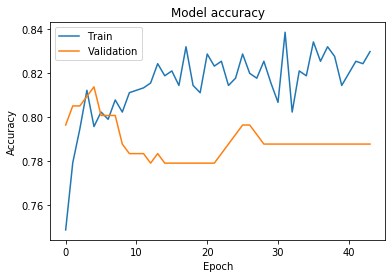

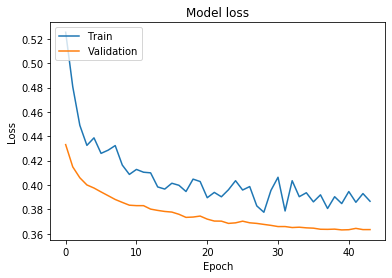

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[112  32]
 [ 21 123]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 21 false negatives and 123 true positives. 

Simple NN Seed 7 Dropout: 0.3
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 7s 81ms/step - loss: 0.5540 - acc: 0.7457 - val_loss: 0.4751 - val_acc: 0.8095

Epoch 00001: val_loss improved from inf to 0.47507, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 73ms/step - loss: 0.4555 - acc: 0.7881 - val_loss: 0.4239 - val_acc: 0.8095

Epoch 00002: val_loss improved from 0.47507 to 0.42393, saving model to ./model/Simple NN Seed 7 Dropout: 0.3_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 75ms/step - loss: 0.4298 - acc: 0.80

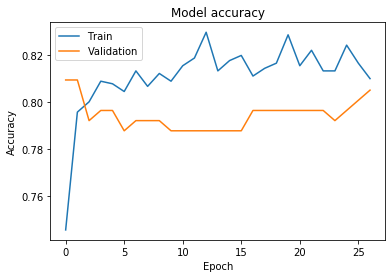

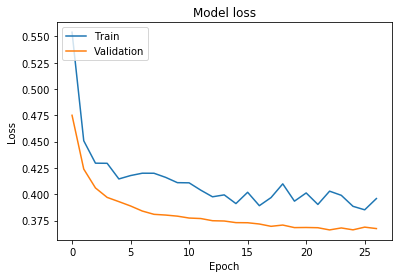

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[115  29]
 [ 22 122]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 22 false negatives and 122 true positives. 

Simple NN Seed 7 Dropout: 0.4
(?, 224, 224, 3)
 1 input shape: (?, 224, 224, 3)
 1 output shape: (?, 2)
Epoch 1/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5719 - acc: 0.7196 - val_loss: 0.4403 - val_acc: 0.7835

Epoch 00001: val_loss improved from inf to 0.44031, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 7s 72ms/step - loss: 0.4660 - acc: 0.8022 - val_loss: 0.4102 - val_acc: 0.8009

Epoch 00002: val_loss improved from 0.44031 to 0.41021, saving model to ./model/Simple NN Seed 7 Dropout: 0.4_Simple_Neural_Network_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 7s 77ms/step - loss: 0.4533 - acc: 0.79

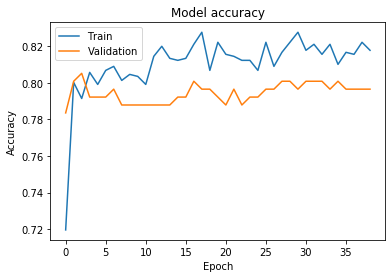

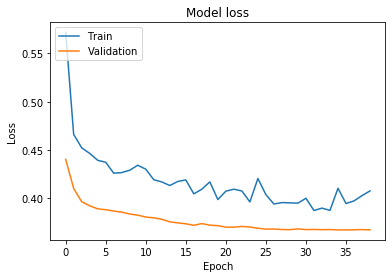

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[115  29]
 [ 23 121]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 23 false negatives and 121 true positives. 

results_data 

   Counter  Simple NN Seed 7 Dropout: 0.2 Val Acc  \
0       0                                  80.52   
1       1                                  82.25   
2       2                                  80.52   
3       3                                  78.79   
4       4                                  80.95   
5       5                                  84.42   
6       6                                  81.82   
7       7                                  83.12   
8       8                                  79.65   
9       9                                  78.79   

   Simple NN Seed 7 Dropout: 0.2 Test Acc  \
0                                   82.64   
1                                   81.94   
2                        

In [13]:
def initiate(folds, X, y):    
    start = time.time()
    print(datetime.now())
    print('X, y shapes: ', X.shape, y.shape)

    #float32 gives faster speed and negligible loss of precision
    X = X.astype('float32')

    #Split the data to get a hold out test set
    sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
    num_splits = sss_initial.get_n_splits(X, y)

    for train_val_index, test_index in sss_initial.split(X, y):
        #print('Train-Validation: ', train_val_index, 'Testing', test_index)

        X_train_val = X[train_val_index].copy()
        y_train_val = y[train_val_index].copy()

        X_test = X[test_index].copy()
        y_test = y[test_index].copy()

        del X, y
        #Image preprocessing
        X_band_train_val = X_train_val[:,:,:,0:3].copy() #Disp, phase and coherence treated as one 3 band image
        X_rgb_train_val = X_train_val[:,:,:,3:6].copy() #RGB Sentinel image 
        print('X_band_train_val processed: max, min', np.max(X_band_train_val), np.min(X_band_train_val))
        print('X_rgb_train_val processed: max, min', np.max(X_rgb_train_val), np.min(X_rgb_train_val))
        X_band_test = X_test[:,:,:,0:3].copy() #Disp, phase and coherence treated as one 3 band image
        X_rgb_test = X_test[:,:,:,3:6].copy() #RGB Sentinel image 
        print('X_band_test processed: max, min', np.max(X_band_test), np.min(X_band_test))
        print('X_rgb_test processed: max, min', np.max(X_rgb_test), np.min(X_rgb_test))

        #Image preprocessing 
        image_size = 224

        del X_train_val, X_test

        results = trainModel(folds, img_res, X_band_train_val, X_band_test, X_rgb_train_val, 
                             X_rgb_test, y_train_val, y_test)

    #Save results to CSV
    results.to_csv('./model/' + 'ConvNet2_Convolutional_Neural_Network_Seed_7_Results.csv', sep=',', index=False)

    end = time.time()
    elapsed = end - start
    print('Total running time (s): %i s' % (elapsed))
    print('Total running time (min.s): %i min.s' % (elapsed/60.0))
    print('Total running time (h): %.2f hours' % (elapsed/3600.0))
    print(datetime.now())
    
initiate(10, X, y)

## Note
- **The results are contained in the *'ConvNet2_Convolutional_Neural_Network_Seed_7_Results.csv'* file in the *model* folder.**